#### Importing essential libraries

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support

#### Loading Datasets

In [53]:
#Classes of nodes(transactions 1 for 'illicit', 2 for 'licit' and third is 'unknown')
classes = pd.read_csv("../Data/elliptic_txs_classes.csv")
classes.head()


,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,2
4,230460314,unknown


In [54]:
#Changing classname of "unknown" to "3"
classes.loc[classes['class'] == 'unknown', 'class'] = '3'
classes.head()

,txId,class
0,230425980,3
1,5530458,3
2,232022460,3
3,232438397,2
4,230460314,3


In [55]:
#Edges between each nodes(transactions) determining the flow of transactions
edges = pd.read_csv("../Data/elliptic_txs_edgelist.csv")
edges.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


In [56]:
features = pd.read_csv("../Data/elliptic_txs_features.csv", header=None)
features.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [57]:
#Checking the shape of the dataset
print('Shape of classes', classes.shape)
print('Shape of edges', edges.shape)
print('Shape of features', features.shape)

Shape of classes (203769, 2)
Shape of edges (234355, 2)
Shape of features (203769, 167)


#### Changing column names

In [58]:
col1 = {'0': 'txId', 1: "Time step"}
col2 = {str(i+2): "Local" + str(i+1) for i in range(93)}
col3 = {str(i+95): "Aggregate" + str(i+1) for i in range(72)}

col = dict(col1, **col2, **col3 )
col = {int(j): item for j,item in col.items()}

In [59]:
features = features.rename(columns=col)
features.head()

,txId,Time step,Local1,Local2,Local3,Local4,Local5,Local6,Local7,Local8,...,Aggregate63,Aggregate64,Aggregate65,Aggregate66,Aggregate67,Aggregate68,Aggregate69,Aggregate70,Aggregate71,Aggregate72
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


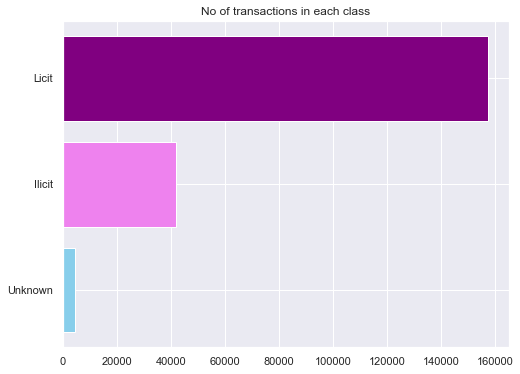

In [60]:
plt.figure(figsize=(8,6))
sns.set_theme(style="darkgrid")
groupclass = classes.groupby('class').count()
plt.barh(['Unknown', 'Ilicit', 'Licit'], groupclass['txId'].values, color=['skyblue', 'violet', 'purple'])
plt.title("No of transactions in each class")
plt.show()

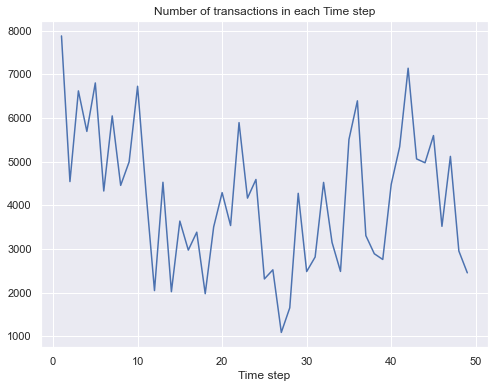

In [61]:
plt.figure(figsize=(8,6))
sns.set_theme(style="darkgrid")
feature = features.groupby('Time step').count()
feature['txId'].plot()
plt.title('Number of transactions in each Time step')
plt.show()

In [62]:
#Plotting the number of transactions per class and timestep

# Merging Class with features
classfeature = pd.merge(classes, features )

groupclassfeature = classfeature.groupby(['Time step', 'class']).count()
groupclassfeature = groupclassfeature['txId'].reset_index().rename(columns={'txId': 'count'})
groupclassfeature.head()

,Time step,class,count
0,1,1,17
1,1,2,2130
2,1,3,5733
3,2,1,18
4,2,2,1099


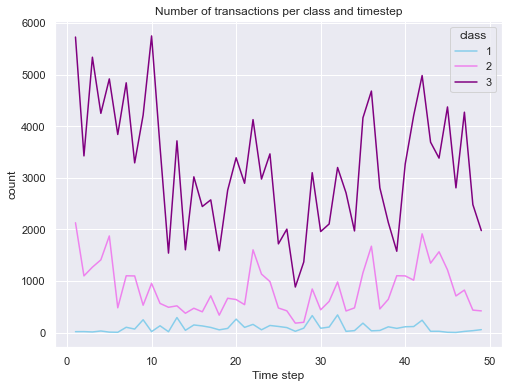

In [63]:
plt.figure(figsize=(8,6))
sns.set_theme(style="darkgrid")
sns.lineplot(x='Time step', y='count', hue='class', data = groupclassfeature, \
             palette=['skyblue', 'violet', 'purple'] )
plt.title("Number of transactions per class and timestep")
plt.show()

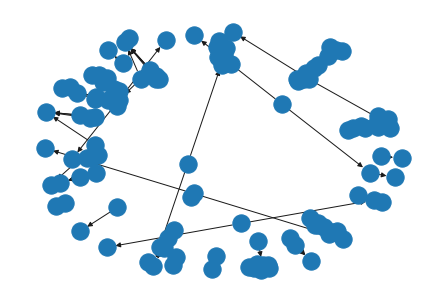

In [64]:
#Plotting graph of ilicit transactions at a given time step

ilicitids = classfeature.loc[(classfeature['Time step'] == 25) & (classfeature['class'] == '1'), 'txId']
ilicitedges = edges.loc[edges['txId1'].isin(ilicitids)]

graph = nx.from_pandas_edgelist(ilicitedges, source = 'txId1', target = 'txId2',\
                                create_using = nx.DiGraph())
pos = nx.spring_layout(graph)
nx.draw(graph, with_labels=False, pos=pos)

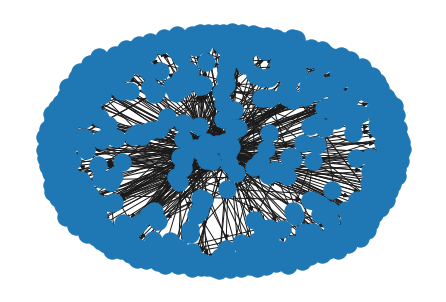

In [65]:
licitids = classfeature.loc[(classfeature['Time step'] == 25) & (classfeature['class'] == '2'), 'txId']
licitedges = edges.loc[edges['txId1'].isin(licitids)]

graph = nx.from_pandas_edgelist(licitedges, source = 'txId1', target = 'txId2',\
                                create_using = nx.DiGraph())
pos = nx.spring_layout(graph)
nx.draw(graph, with_labels=False, pos=pos)

#### Model training and Prediction

In [51]:
selectedids = classfeature.loc[(classfeature['class'] != '3'), 'txId']
edgesselected = edges.loc[edges['txId1'].isin(selectedids)]
classesselected = classes.loc[classes['txId'].isin(selectedids)]
featuresselected = features.loc[features['txId'].isin(selectedids)]

# Merge Class and features
classfeatureselected = pd.merge(classesselected, featuresselected )
classfeatureselected.head()

,txId,class,Time step,Local1,Local2,Local3,Local4,Local5,Local6,Local7,...,Aggregate63,Aggregate64,Aggregate65,Aggregate66,Aggregate67,Aggregate68,Aggregate69,Aggregate70,Aggregate71,Aggregate72
0,232438397,2,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
1,232029206,2,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,...,-0.577099,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792
2,232344069,2,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
3,27553029,2,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.539735,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
4,3881097,2,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,...,-0.577099,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984


In [39]:
# drop class, text id and time step
X = classfeatureselected.drop(columns=['txId', 'class', 'Time step']) 
y = classfeatureselected[['class']]

# class 2 corresponds to licit transactions, we change this to 0 as our interest is the ilicit transactions
y = y['class'].apply(lambda x: 0 if x == '2' else 1 )

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=15)

In [41]:
model = RandomForestClassifier().fit(X_train.values,y_train.values)
y_preds = model.predict(X_test.values)

prec,rec,f1,num = precision_recall_fscore_support(y_test.values, y_preds)

print("Random Forest Classifier")
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))

Random Forest Classifier
Precision:0.998 
Recall:0.888 
F1 Score:0.940


#### Predicting 'unknown' transactions

In [43]:
# Selecting 'unknown' ids

unknownids = classfeature.loc[(classfeature['class'] == 3), 'txId']

edgesunknown = edges.loc[edges['txId1'].isin(unknownids)]
classesunknown = classes.loc[classes['txId'].isin(unknownids)]
featuresunknown = features.loc[features['txId'].isin(unknownids)]

In [44]:
#Predicting Class
X_unknown = featuresunknown.drop(columns=['txId', 'Time step'])
y_unknown_preds = model.predict(X_unknown.values)

In [45]:
#Replacing 'unknown' class with the predicted one
classesunknown = classesunknown.copy()
classesunknown.loc[:, 'class'] = y_unknown_preds

In [46]:
#Merge class and features
classfeatureunknown = pd.merge(classesunknown, featuresunknown )
classfeatureunknown.head()

,txId,class,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,...,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72
0,230425980,0,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,0,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,0,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,230460314,0,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
4,230459870,0,1,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,...,-0.504702,-0.422589,-0.226790,-0.117629,0.018279,0.277775,0.413931,1.149556,-0.696053,-0.695540


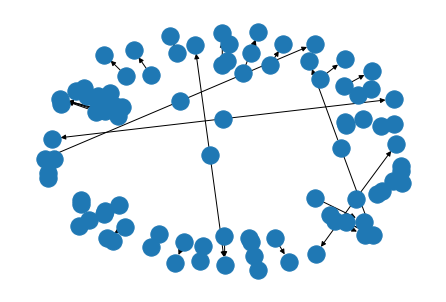

In [48]:
#Predicted graph
ilicitids = classfeatureunknown.loc[(classfeatureunknown['Time step'] == 25) & \
                                    (classfeatureunknown['class'] == 1), 'txId']
ilicitedges = edgesunknown.loc[edgesunknown['txId1'].isin(ilicitids)]

graph = nx.from_pandas_edgelist(ilicitedges, source = 'txId1', target = 'txId2', 
                                 create_using = nx.DiGraph())
pos = nx.spring_layout(graph)
nx.draw(graph, with_labels=False, pos=pos)